In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt  
from ipywidgets import widgets
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

%matplotlib inline

In [2]:
har_ds = pd.read_table('dataset-har-pair-fb.csv',sep=';')

C:\Users\jennhaur\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#f = lambda x : x[0]+x[1]
#har_ds['height'] = har_ds['how_tall_in_meters'].str.split(",").apply(f).astype(int)
har_ds['height'] = har_ds['how_tall_in_meters'].str.split(",").apply(lambda x : x[0]+x[1]).astype(int)
del har_ds['how_tall_in_meters']

In [4]:
#f = lambda x : int(x[0])+int(x[1])/10
#har_ds['body_mass_index'].str.split(",").apply(lambda x : int(x[0])+int(x[1])/10)
har_ds['bmi'] = har_ds['body_mass_index'].str.split(",").apply(lambda x : int(x[0])+int(x[1])/10)
del har_ds['body_mass_index']

In [5]:
#pd.unique(har_ds['z4'])
#har_ds['z4'].to_numeric()
#har_ds['z4'].astype(int)

har_ds['z4'] = har_ds['z4'].convert_objects(convert_numeric=True)
har_ds.dtypes


C:\Users\jennhaur\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


user       object
gender     object
age         int64
weight      int64
x1          int64
y1          int64
z1          int64
x2          int64
y2          int64
z2          int64
x3          int64
y3          int64
z3          int64
x4          int64
y4          int64
z4        float64
class      object
height      int32
bmi       float64
dtype: object

In [ ]:


#Option 1
#fig, ax = plt.subplots(5,1,sharex=True)
#har_ds[['class','x1']].groupby('class').boxplot(subplots=True,layout=(1,5),figsize=(15,3),sym="")

#Option 2
#show outliers
#har_ds[['class','x1']].boxplot(by='class',sym="k.")
#ignore outliers
har_ds[['class','x1']].boxplot(by='class',sym="")
har_ds[['class','x2']].boxplot(by='class',sym="")
har_ds[['class','x3']].boxplot(by='class',sym="")
har_ds[['class','x4']].boxplot(by='class',sym="")
har_ds[['class','x1','x2','x3','x4']].boxplot(by='class',sym="")

#Option 3
#df = har_ds[['class','x1']]
#df2 = df.pivot(columns=df.columns[0])
#df2.boxplot()
        

In [ ]:
df = har_ds[['class','x1','x2']]
groups = df[(df['class'] == "sitting") | (df['class'] == "standing")].groupby('class')

groups.plot(x=groups['x1'],y=groups['x2'],kind='scatter',subplots=True,layout=(1,2),figsize=(15,30),legends=True)

#Option 2
#fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in groups:
#     ax.plot(group.x1, group.x2, marker='o', linestyle='', ms=12, label=name)
# ax.legend()
# plt.show()

#har_ds.plot.scatter(x='x1',y='x2')
#har_ds[['class','x1','x2']].groupby('class').plot.scatter(subplots=True,layout=(1,5),figsize=(15,3),sym="")



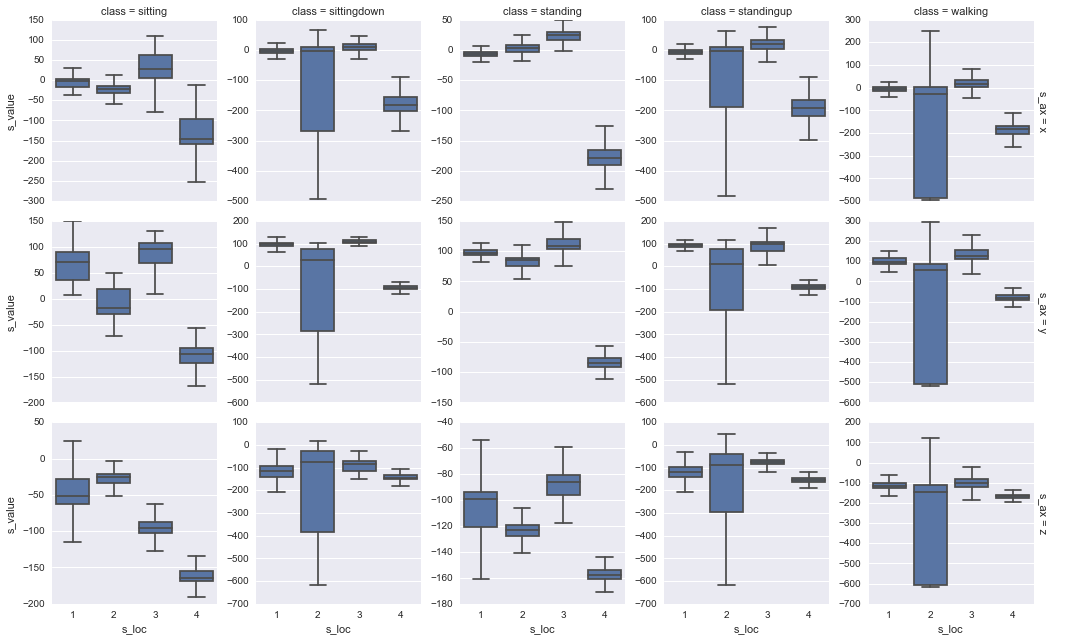

In [6]:
#x1 = waist, x2 = thigh, x3 = ankle, x4 = arm

#g = sb.FacetGrid(har_ds,col='class')
#g.map(plt.scatter,"x1","x2")
#g.map(plt.hist,"x1")

# g1 = sb.FacetGrid(har_ds,col='class',row='gender',margin_titles=True)
# g1.map(plt.scatter,'x1','x2')
# g1.add_legend()

# g2 = sb.FacetGrid(har_ds,col='class',sharey=False,margin_titles=True)
# g2.map(sb.boxplot,'gender','x1')
# g2.add_legend()

#Stacking
df = har_ds.set_index(['user','gender','class','weight','bmi','height','age'])
df = df.stack().reset_index()
df.columns = ['user','gender','class','weight','bmi','height','age','s_axis','s_value']
df['s_loc'] = df['s_axis'].apply(lambda x: x[1:2])
df['s_ax'] = df['s_axis'].apply(lambda x: x[:1])

#dff = df[(df['s_ax'] == "x")]
g3 = sb.FacetGrid(df,col='class',row='s_ax',sharey=False,margin_titles=True)
g3.map(sb.boxplot,'s_loc','s_value',sym="")
g3.add_legend()

In [7]:
#Data Cleansing NaN
# %timeit har_ds.isnull().any()
#har_ds.isnull().sum()

har_ds.isnull().any()
har_ds.loc[har_ds['z4'].isnull().nonzero()]

har_ds_new = har_ds.drop(har_ds.index[122076])
#har_ds_new.loc[har_ds_new['z4'].isnull().nonzero()]
har_ds_new.isnull().any()

user      False
gender    False
age       False
weight    False
x1        False
y1        False
z1        False
x2        False
y2        False
z2        False
x3        False
y3        False
z3        False
x4        False
y4        False
z4        False
class     False
height    False
bmi       False
dtype: bool

In [8]:
#Pandas Dummies to change Classes to One-Hot Encoding
har_ds_oh = pd.get_dummies(har_ds_new)

In [9]:
pd.unique(har_ds['user'])
har_ds_oh.columns.values

array(['age', 'weight', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3',
       'z3', 'x4', 'y4', 'z4', 'height', 'bmi', 'user_debora',
       'user_jose_carlos', 'user_katia', 'user_wallace', 'gender_Man',
       'gender_Woman', 'class_sitting', 'class_sittingdown',
       'class_standing', 'class_standingup', 'class_walking'], dtype=object)

C4.5 Decision Tree / ID3 / Adaboost ? Adaboost with 10 iteration, C4.5 confidence factor 0.25
http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#example-tree-plot-iris-py
http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#example-ensemble-plot-adaboost-hastie-10-2-py


In [10]:
# Split to training set and test set , cross validation
# Random Forest

# 99.4% using 10-fold cross validation (sitting 100%, sitting down 96.9% , standing 99.8% , standing up 96.9% walking 99.8%)
# Confusion Matrix


X = har_ds_oh[['age', 'weight', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3','z3', 'x4', 'y4', 'z4', 'height', 'bmi', 
    'user_debora','user_jose_carlos', 'user_katia', 'user_wallace', 'gender_Man','gender_Woman']].values
y = har_ds_oh[['class_sitting', 'class_sittingdown','class_standing', 'class_standingup', 'class_walking']].values
X_train, X_test, y_train , y_test = train_test_split(X,y)
pipeline = Pipeline([('clf',DecisionTreeClassifier(criterion='entropy'))])
parameters = {
    'clf__max_depth' : [5,6,7],
    'clf__min_samples_split' : [1,2,3],
    'clf__min_samples_leaf' : [1,2,3]
}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,verbose=1,scoring='f1',cv=10)
grid_search.fit(X_train,y_train)

print('Best score: %0.3f') % grid_search.best_score_
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print('\t%s: %r') % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
classification_report(y_test, predictions)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min


KeyboardInterrupt: 

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# visualize_tree(dt_ts_gs, features, fn="grid_best")
# bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=600,learning_rate=1)

#print importance features : compute_importance=True
#print tree graph